### BERT_Base (uncased) model is downloaded from Tensorflow Hub.

### BERT_Base: L=12 hidden layers (i.e., Transformer blocks), a hidden size of H=768, and A=12 attention heads. Input sentences are cased.

In [1]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 2650, done.
remote: Counting objects: 100% (2650/2650), done.
remote: Compressing objects: 100% (2311/2311), done.
remote: Total 2650 (delta 506), reused 1388 (delta 306), pack-reused 0
Receiving objects: 100% (2650/2650), 34.02 MiB | 13.91 MiB/s, done.
Resolving deltas: 100% (506/506), done.
Note: checking out '400d68abbccda2f0f6609e3a924467718b144233'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>



In [2]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt
# you may have to restart the runtime afterwards

     |████████████████████████████████| 8.3 MB 4.2 MB/s 
     |████████████████████████████████| 206 kB 48.7 MB/s 
     |████████████████████████████████| 280 kB 51.0 MB/s 
     |████████████████████████████████| 99 kB 8.8 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
     |████████████████████████████████| 237 kB 53.1 MB/s 
     |████████████████████████████████| 4.2 MB 23.7 MB/s 
     |████████████████████████████████| 1.1 MB 43.1 MB/s 
     |████████████████████████████████| 352 kB 53.2 MB/s 
     |████████████████████████████████| 1.2 MB 43.6 MB/s 
     |████████████████████████████████| 11.2 MB 35.7 MB/s 
     |████████████████████████████████| 47.8 MB 60 kB/s 
     |████████████████████████████████| 596 kB 47.9 MB/s 
     |████████████████████████████████| 4.3 MB 34.5 MB/s 
     |████████████████████████████████| 114 kB 55.4 MB/s 
     |████████████████████████████████| 76 kB 5.0 MB/s 
     |████████████████████████████████| 46 kB 3.1 MB/s 
     |███████████████

In [3]:
!pip install tensorflow-text

     |████████████████████████████████| 4.9 MB 4.4 MB/s 
     |████████████████████████████████| 462 kB 41.3 MB/s 


In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization
import tensorflow_text as text

In [5]:
print("TF Version: ", tf.__version__)
print("Hub version: ", hub.__version__)

TF Version:  2.8.0
Hub version:  0.12.0


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## Load Data

In [7]:
df = pd.read_csv("/content/spamdata_v2.csv")
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
df.shape

(5572, 2)

In [9]:
pip install matplotlib==3.1.3

     |████████████████████████████████| 13.1 MB 4.1 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


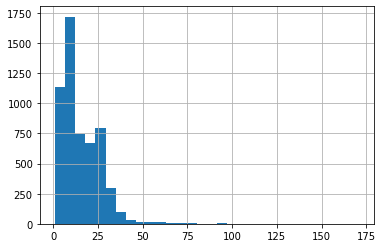

In [10]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in df['text']]

pd.Series(seq_len).hist(bins = 30)

In [11]:
# check class distribution
#df['label'].value_counts(normalize = True)
df['label'].value_counts()

0    4825
1     747
Name: label, dtype: int64

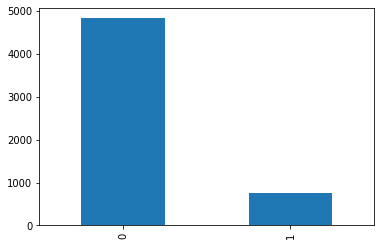

In [12]:
# Visualize SCORE distribution, total 11 scores, majority SCORE = 10
df['label'].value_counts().plot(kind = 'bar')

## Preprocessing Sentence

In [13]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

In [14]:
# Define preprocess function, remove stop words and punctuations etc.
# BERT does not need Lemming/stemming nor removing stopwords to work. 
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import string
stop = set(stopwords.words('english'))
punc = set(string.punctuation)
lemma = WordNetLemmatizer()
def clean_text(text):
    text = text.lower()
    wordList = text.split()
    wordList = ["".join(x for x in word if (x=="'")|(x not in punc)) for word in wordList]
    wordList = [word for word in wordList if word not in stop]
    wordList = [lemma.lemmatize(word) for word in wordList]
    return " ".join(wordList)
clean_text("I Thank you!")

'thank'

In [ ]:
# Clean train dataset
df["text"] = df["text"].astype("str")
df["clean_text"] = df["text"].apply(clean_text)

## Create tf.data.Datasets for Training and Evaluation

Split dataset: training: 70 %, Validation: 15 %, testing: 15 %.

In [15]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=42, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=42, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [16]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_text.values, train_labels.values))
  val_data = tf.data.Dataset.from_tensor_slices((val_text.values, val_labels.values))
  test_data = tf.data.Dataset.from_tensor_slices((test_text.values, test_labels.values))

  for text, label in train_data.take(1):
    print(text)
    print(label)

tf.Tensor(b'Goal! Arsenal 4 (Henry, 7 v Liverpool 2 Henry scores with a simple shot from 6 yards from a pass by Bergkamp to give Arsenal a 2 goal margin after 78 mins.', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)


##Download a Pre-trained BERT Model from TensorFlow Hub

In [17]:
"""
Each line of the dataset is composed of text text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""

# maximum length of (token) input sequences
max_seq_length = 128  # should be based on the distribution

train_batch_size = 32



In [18]:
# Get BERT layer and tokenizer
bert_layer = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
tokenizer = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [19]:
# see an example of tokenization
bert_tokenizer = hub.load(tokenizer)

bert_tokenizer.tokenize(['hi, how are you doing?'])

<tf.RaggedTensor [[[7632],
  [1010],
  [2129],
  [2024],
  [2017],
  [2725],
  [1029]]]>

In [20]:
# create keras layers to preprocess the text and encode to fit to the bert model

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name = 'inputs')

# preprocessing
preprocessor = hub.KerasLayer(tokenizer)
encoder_inputs = preprocessor(text_input)

preprocess_model = tf.keras.Model(text_input, encoder_inputs)

preprocess_model(tf.constant(['hi, how are you doing?']))

{'input_mask': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
 array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 

##Create a TensorFlow Input Pipeline with tf.data

In [21]:
with tf.device('/cpu:0'):
  # train
  train_data = train_data.shuffle(1000).batch(32, drop_remainder = True).prefetch(tf.data.experimental.AUTOTUNE)

  # valid
  val_data = val_data.batch(32, drop_remainder = True).prefetch(tf.data.experimental.AUTOTUNE)
  

In [22]:
# train data spec
train_data.element_spec

(TensorSpec(shape=(32,), dtype=tf.string, name=None),
 TensorSpec(shape=(32,), dtype=tf.int64, name=None))

In [23]:
# valid data spec
val_data.element_spec

(TensorSpec(shape=(32,), dtype=tf.string, name=None),
 TensorSpec(shape=(32,), dtype=tf.int64, name=None))

##Add a Classification Head to the BERT Layer

In [24]:
# Building the model
def create_model():
  
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name = 'inputs')

  # preprocessing
  preprocessor = hub.KerasLayer(tokenizer)
  encoder_inputs = preprocessor(text_input)

  # passing the encoded inputs to bert model
  encoder = hub.KerasLayer(bert_layer, trainable=True, name = 'BERT_Encoder')
  outputs = encoder(encoder_inputs)

  # get the pooled outputs
  pooled_output = outputs['pooled_output']

  # add output layer
  batch_norm = tf.keras.layers.BatchNormalization()(pooled_output)
  drop = tf.keras.layers.Dropout(0.4)(batch_norm)
  fc = tf.keras.layers.Dense(512, activation='relu')(drop)
  #final_output = tf.keras.layers.Dense(3, activation='softmax', name='classifier')(fc)
  final_output = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(fc)  
  return tf.keras.Model(text_input, final_output)
  

##Fine-Tune BERT for Text Classification

Use sparse categorical crossentropy when your classes are mutually exclusive (e.g. when each sample belongs exactly to one class) and categorical crossentropy when one sample can have multiple classes or labels are soft probabilities (like [0.5, 0.3, 0.2]).

In [25]:
model = create_model()
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
              #loss = tf.keras.losses.CategoricalCrossentropy(), # use binary_crossentropy
              #metrics = [tf.keras.metrics.Accuracy()]) 
              #loss = tf.keras.losses.BinaryCrossentropy(),
              #metrics = [tf.keras.metrics.BinaryAccuracy()])

In [26]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None,)]            0           []                               
                                                                                                  
 keras_layer_1 (KerasLayer)     {'input_word_ids':   0           ['inputs[0][0]']                 
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

In [27]:
# Train model
epochs = 5
history = model.fit(train_data, 
                    validation_data=val_data,
                    epochs=epochs, 
                    verbose=1)

Epoch 1/5
121/121 [==============================] - 238s 2s/step - loss: 0.2002 - accuracy: 0.9254 - val_loss: 0.0829 - val_accuracy: 0.9892
Epoch 2/5
121/121 [==============================] - 217s 2s/step - loss: 0.0461 - accuracy: 0.9907 - val_loss: 0.0411 - val_accuracy: 0.9904
Epoch 3/5
121/121 [==============================] - 217s 2s/step - loss: 0.0237 - accuracy: 0.9943 - val_loss: 0.0377 - val_accuracy: 0.9928
Epoch 4/5
121/121 [==============================] - 217s 2s/step - loss: 0.0144 - accuracy: 0.9972 - val_loss: 0.0924 - val_accuracy: 0.9712
Epoch 5/5
121/121 [==============================] - 217s 2s/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.0353 - val_accuracy: 0.9940


In [28]:
model.save('/content/bert_model.h5')

In [39]:
model=tf.keras.models.load_model("/content/bert_model.h5", custom_objects={'KerasLayer':hub.KerasLayer})

##Evaluate the BERT Text Classification Model

In [29]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

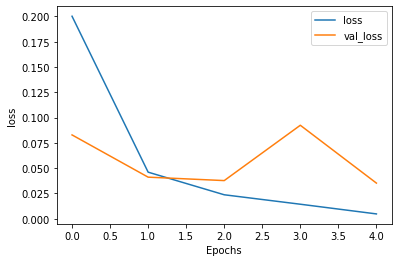

In [30]:
plot_graphs(history=history, metric='loss')

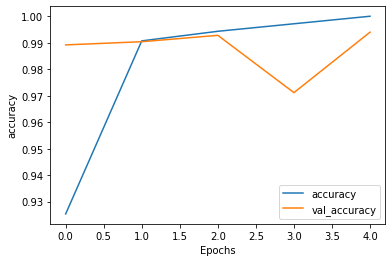

In [31]:
plot_graphs(history,'accuracy')

In [32]:
with tf.device('/cpu:0'):
  # test
  xtest = test_data.batch(32, drop_remainder = True).prefetch(tf.data.experimental.AUTOTUNE)

In [33]:
loss, accuracy = model.evaluate(xtest)

26/26 [==============================] - 17s 650ms/step - loss: 0.0267 - accuracy: 0.9940


### Summary:
 
BERT_Base with uncased inputs, model trainable = True, training acc 0.9999, validation acc 0.9940, testing acc 0.9940. 

After 1 epoch shows overfitting.
   
